In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.metrics import cohen_kappa_score

import torch

from src.config import ProjectPaths, read_train
from src.ES_dataset import create_dataloaders, EssayDataset, collate_batch
from src.ES_model import EssayClassifierModel

import matplotlib.pyplot as plt
import seaborn as sns
from src.styles import set_styles, TXT_ACC, TXT_RESET, PALETTE
set_styles()

from warnings import filterwarnings
filterwarnings('ignore')

C:\Users\Hawkins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = read_train()
df_clusters = pd.read_csv('data/train_clusters.csv')

df_train = df_train.merge(df_clusters, on='essay_id')
df_train.query('clusters7 == 3')[['essay_id', 'full_text', 'score', 'fold']].to_csv('data/train_cluster3.csv', index=False)

df_cluster3 = pd.read_csv('data/train_cluster3.csv')

In [3]:
df_cluster3['fold'].value_counts()

fold
2.0    356
4.0    336
1.0    333
3.0    322
0.0    301
Name: count, dtype: int64

# OOF cluster 3

In [4]:
def print_score_preds(model_path, model_name):
    device = torch.device('cuda')

    checkpoint = torch.load(model_path)

    model = EssayClassifierModel(model_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    dataloader_train, dataloader_valid = create_dataloaders(ProjectPaths.train_cluster3, fold=0, model_name=model_name, batch_size=1)

    outputs = np.empty(len(dataloader_valid), dtype=int)
    targets = np.empty(len(dataloader_valid), dtype=int)

    for b, batch in enumerate(tqdm(dataloader_valid)):
        output = model(collate_batch(batch['inputs']).to(device)).cpu().detach().numpy().argmax(axis=1)
        target = batch['labels'].cpu().detach().numpy()
        outputs[b] = output
        targets[b] = target

    score = cohen_kappa_score(targets, outputs, weights='quadratic')
    print(f'score {score: .4f}')

    return targets, outputs


def display_distributions(targets, outputs, title):
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2))

    sns.barplot(pd.Series(targets + 1).value_counts(), ax=ax, alpha=0.5, label='target')
    sns.barplot(pd.Series(outputs + 1).value_counts(), ax=ax, alpha=0.5, label='predictions')
    ax.set_title(title, fontsize=10)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [5]:
path_model_on_whole_dataset = 'trained_models/rifx9c0m_best_model.pth'
path_model_small_cluster3   = 'trained_models/tf0sbjpt_best_model.pth'
path_model_xsmall_cluster3  = 'trained_models/9tj656gj_best_model.pth'

 Deberta-v3-small tuned on the whole dataset 


100%|██████████| 301/301 [00:19<00:00, 15.60it/s]


score  0.6991


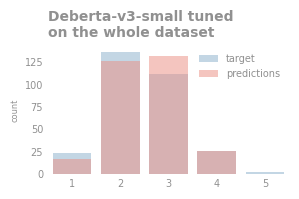

In [6]:
print(f'{TXT_ACC} Deberta-v3-small tuned on the whole dataset {TXT_RESET}')
targets_whole, outputs_whole = print_score_preds(path_model_on_whole_dataset, 'microsoft/deberta-v3-small')
display_distributions(targets_whole, outputs_whole, 'Deberta-v3-small tuned\non the whole dataset')

 Deberta-v3-small tuned on cluster 3 


100%|██████████| 301/301 [00:18<00:00, 16.26it/s]


score  0.6881


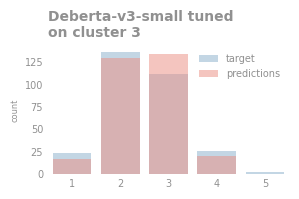

In [7]:
print(f'{TXT_ACC} Deberta-v3-small tuned on cluster 3 {TXT_RESET}')
targets_small, outputs_small = print_score_preds(path_model_small_cluster3, 'microsoft/deberta-v3-small')
display_distributions(targets_small, outputs_small, 'Deberta-v3-small tuned\non cluster 3')

 Deberta-v3-xsmall on cluster 3 


100%|██████████| 301/301 [00:15<00:00, 19.46it/s]


score  0.6853


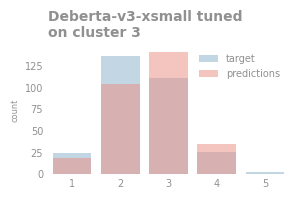

In [8]:
print(f'{TXT_ACC} Deberta-v3-xsmall on cluster 3 {TXT_RESET}')
targets_xsmall, outputs_xsmall = print_score_preds(path_model_xsmall_cluster3, 'microsoft/deberta-v3-xsmall')
display_distributions(targets_xsmall, outputs_xsmall, 'Deberta-v3-xsmall tuned\non cluster 3')